Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       125
           1       0.97      0.91      0.94       308

    accuracy                           0.91       433
   macro avg       0.88      0.92      0.90       433
weighted avg       0.92      0.91      0.91       433

Confusion Matrix:


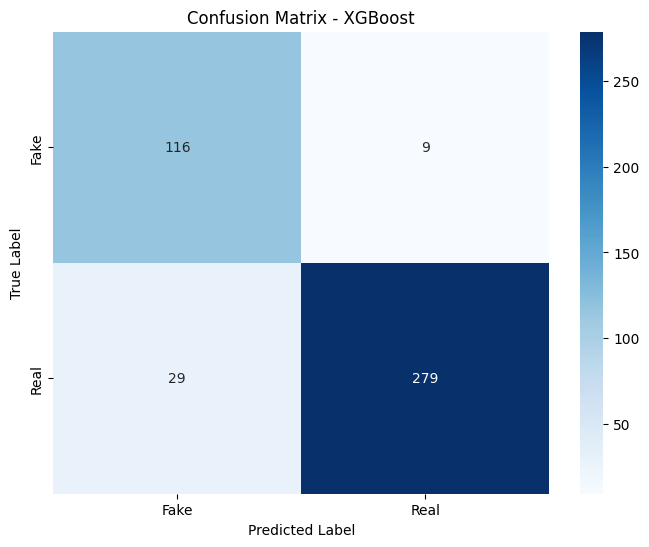

Accuracy of the model: 0.9122401847575058


In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
warnings.filterwarnings("ignore", category=FutureWarning)


# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Load the updated datasets (fake and real news content)
fake_news_file_path = '/Users/hariharanduraisingh/Downloads/jupyter_notebook/CoAID/05-01-2020/NewsFakeCOVID-19.csv'
real_news_file_path = '/Users/hariharanduraisingh/Downloads/jupyter_notebook/CoAID/05-01-2020/NewsRealCOVID-19.csv'

fake_news_df = pd.read_csv(fake_news_file_path)
real_news_df = pd.read_csv(real_news_file_path)

# Step 3: Preprocessing the Data
# Handle missing values by filling NaN entries in 'title' and 'content' columns with empty strings
fake_news_df['title'] = fake_news_df['title'].fillna('')
fake_news_df['content'] = fake_news_df['content'].fillna('')
real_news_df['title'] = real_news_df['title'].fillna('')
real_news_df['content'] = real_news_df['content'].fillna('')

# Step 4: Extract features (title + content) and labels
X_fake = fake_news_df['title'] + " " + fake_news_df['content']
X_real = real_news_df['title'] + " " + real_news_df['content']

y_fake = [0] * len(X_fake)  # Label fake news as 0
y_real = [1] * len(X_real)  # Label real news as 1

X = pd.concat([X_fake, X_real], ignore_index=True)  # Features (title + content)
y = y_fake + y_real  # Labels (0 for fake, 1 for real)

# Step 5: Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: Convert text data (title + content) into numerical data using TF-IDF Vectorizer (using n-grams)
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))  # Using bigrams
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Step 7: Initialize XGBoost Classifier with the best parameters found
xgb_classifier = XGBClassifier(
    learning_rate=0.1,         
    max_depth=3,               
    n_estimators=400,          
    subsample=1.0,             
    min_child_weight=1,        
    colsample_bytree=0.8,      
    random_state=42, 
    eval_metric='mlogloss',    
    use_label_encoder=False    
)

# Step 8: Apply SMOTE to balance the classes by oversampling the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Step 9: Train the XGBoost model
xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Step 10: Predict on the test set
y_pred = xgb_classifier.predict(X_test_tfidf)

# Step 11: Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)

# Visualizing confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title('Confusion Matrix - XGBoost')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Step 12: Accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the model: {accuracy}")
